# 🎯 3. Modelling
## 3.1 Tujuan

Tahap modelling bertujuan untuk membangun model machine learning yang mampu mengklasifikasikan suara “buka” dan “tutup” berdasarkan fitur-fitur statistik seperti:

* Mean

* Standard Deviation

* Skewness

* Kurtosis

* RMS (Root Mean Square)

* Zero Crossing Rate

## 3.2 Pemilihan Model

Tiga algoritma yang digunakan untuk perbandingan performa adalah:

1. K-Nearest Neighbors (KNN) — sederhana dan cocok untuk data berdimensi kecil.

2. Random Forest (RF) — menangani non-linearitas dan fitur-fitur yang saling berinteraksi.

3. Naive Bayes (NB) — efisien untuk data numerik dengan distribusi sederhana.

## 3.3 Implementasi

Berikut contoh skrip Python tahap modelling (lanjutan dari preprocessing):

=== Evaluasi Model ===
KNN Accuracy          : 1.00
Random Forest Accuracy: 1.00
Naive Bayes Accuracy  : 1.00

🏆 Model terbaik: RandomForest dengan akurasi 1.00


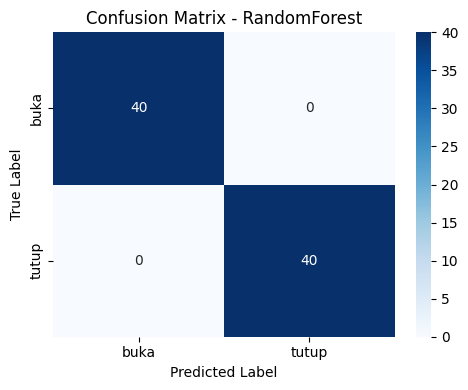


=== Classification Report ===
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        40
       tutup       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


✅ Model 'RandomForest' dan scaler berhasil disimpan ke file .pkl


In [6]:
# =====================================
# 🧠 Tahap: Modelling + Save Model
# =====================================

import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================
# 📂 Load Dataset Bersih
# =====================================
df = pd.read_csv('fitur_statistik_bukatutup_clean.csv')

# Pisahkan fitur dan label
X = df.drop(columns=['label'])
y = df['label']

# Split data train-test (stratify untuk jaga proporsi buka/tutup)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================
# 🔹 Model 1: K-Nearest Neighbors
# =====================================
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)

# =====================================
# 🔹 Model 2: Random Forest
# =====================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# =====================================
# 🔹 Model 3: Naive Bayes
# =====================================
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
acc_nb = accuracy_score(y_test, y_pred_nb)

# =====================================
# 📊 Evaluasi Model
# =====================================
print("=== Evaluasi Model ===")
print(f"KNN Accuracy          : {acc_knn:.2f}")
print(f"Random Forest Accuracy: {acc_rf:.2f}")
print(f"Naive Bayes Accuracy  : {acc_nb:.2f}")

# Pilih model terbaik
best_model = None
best_name = ""
y_pred_best = None

if acc_rf >= acc_knn and acc_rf >= acc_nb:
    best_model = rf
    best_name = "RandomForest"
    y_pred_best = y_pred_rf
elif acc_knn >= acc_rf and acc_knn >= acc_nb:
    best_model = knn
    best_name = "KNN"
    y_pred_best = y_pred_knn
else:
    best_model = nb
    best_name = "NaiveBayes"
    y_pred_best = y_pred_nb

print(f"\n🏆 Model terbaik: {best_name} dengan akurasi {max(acc_knn, acc_rf, acc_nb):.2f}")

# =====================================
# 📉 Confusion Matrix & Classification Report
# =====================================
cm = confusion_matrix(y_test, y_pred_best, labels=y.unique())
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_best))

# =====================================
# 💾 Simpan Model dan Scaler
# =====================================
with open(f'model_{best_name}.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print(f"\n✅ Model '{best_name}' dan scaler berhasil disimpan ke file .pkl")
